### Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
keras = tf.keras

2024-03-05 20:16:11.412124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 20:16:14.914298: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 20:16:14.925749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 20:16:28.368971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
def plot_series(time, series, format = '-', start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)
    
def trend(time, slope = 0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

#### Time and seasonality

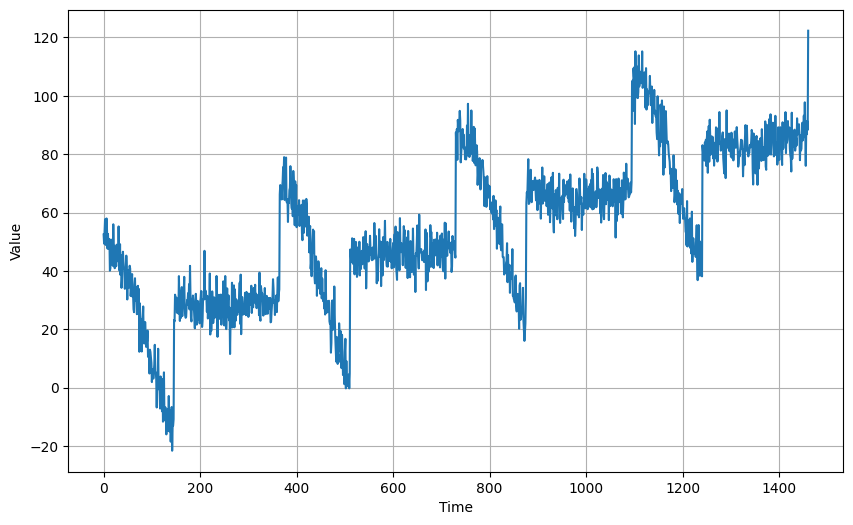

In [8]:
time = np.arange(4 * 365 + 1)

slope = .05
baseline = 10
amplitude = 40

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

#### Split data

In [9]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Stateful RNN Forecasting

#### Windowing

In [10]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [11]:
for x, y in sequential_window_dataset(tf.range(10), 3):
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[[0]
  [1]
  [2]]]
y =  [[[1]
  [2]
  [3]]]
x =  [[[1]
  [2]
  [3]]]
y =  [[[2]
  [3]
  [4]]]
x =  [[[2]
  [3]
  [4]]]
y =  [[[3]
  [4]
  [5]]]
x =  [[[3]
  [4]
  [5]]]
y =  [[[4]
  [5]
  [6]]]
x =  [[[4]
  [5]
  [6]]]
y =  [[[5]
  [6]
  [7]]]
x =  [[[5]
  [6]
  [7]]]
y =  [[[6]
  [7]
  [8]]]
x =  [[[6]
  [7]
  [8]]]
y =  [[[7]
  [8]
  [9]]]


#### Reset the state of model after every epoch

In [12]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

#### Find the best learning rate

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences = True, stateful = True,
                          batch_input_shape = [1, None, 1]),
    keras.layers.SimpleRNN(100, return_sequences = True, stateful = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epochs: 1e-8 * 10 ** (epochs / 30))

reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate = 1e-8, momentum = .9)
model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

history = model.fit(train_set, epochs = 100,
                   callbacks = [lr_schedule, reset_states])

Epoch 1/100
970/970 [==============================] - 11s 9ms/step - loss: 13.8738 - mae: 14.3632 - lr: 1.0000e-08
Epoch 2/100
970/970 [==============================] - 9s 9ms/step - loss: 11.3673 - mae: 11.8536 - lr: 1.0798e-08
Epoch 3/100
970/970 [==============================] - 9s 9ms/step - loss: 10.3400 - mae: 10.8242 - lr: 1.1659e-08
Epoch 4/100
970/970 [==============================] - 8s 9ms/step - loss: 9.3676 - mae: 9.8522 - lr: 1.2589e-08
Epoch 5/100
970/970 [==============================] - 9s 9ms/step - loss: 8.6061 - mae: 9.0886 - lr: 1.3594e-08
Epoch 6/100
970/970 [==============================] - 10s 11ms/step - loss: 8.0360 - mae: 8.5185 - lr: 1.4678e-08
Epoch 7/100
970/970 [==============================] - 9s 10ms/step - loss: 7.6343 - mae: 8.1154 - lr: 1.5849e-08
Epoch 8/100
970/970 [==============================] - 10s 10ms/step - loss: 7.3531 - mae: 7.8339 - lr: 1.7113e-08
Epoch 9/100
970/970 [==============================] - 9s 10ms/step - loss: 7.1491 -

Epoch 72/100
970/970 [==============================] - 10s 11ms/step - loss: 4.7764 - mae: 5.2516 - lr: 2.3263e-06
Epoch 73/100
970/970 [==============================] - 10s 10ms/step - loss: 4.8522 - mae: 5.3281 - lr: 2.5119e-06
Epoch 74/100
970/970 [==============================] - 11s 11ms/step - loss: 4.8100 - mae: 5.2853 - lr: 2.7123e-06
Epoch 75/100
970/970 [==============================] - 11s 11ms/step - loss: 4.7250 - mae: 5.1995 - lr: 2.9286e-06
Epoch 76/100
970/970 [==============================] - 10s 10ms/step - loss: 4.7481 - mae: 5.2228 - lr: 3.1623e-06
Epoch 77/100
970/970 [==============================] - 10s 10ms/step - loss: 4.7329 - mae: 5.2083 - lr: 3.4145e-06
Epoch 78/100
970/970 [==============================] - 11s 11ms/step - loss: 4.8420 - mae: 5.3185 - lr: 3.6869e-06
Epoch 79/100
970/970 [==============================] - 12s 12ms/step - loss: 4.7498 - mae: 5.2255 - lr: 3.9811e-06
Epoch 80/100
970/970 [==============================] - 10s 11ms/step - 

(1e-08, 0.0001, 0.0, 30.0)

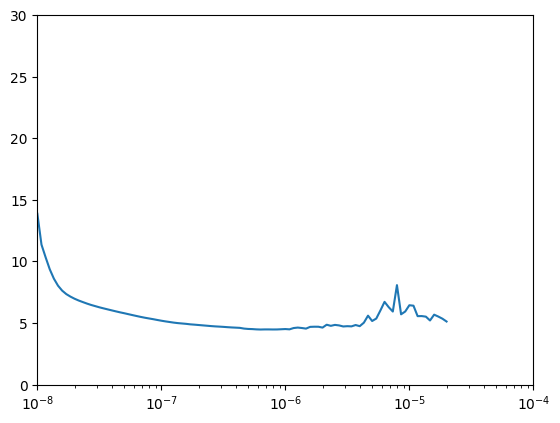

In [15]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

### Build stateful rnn model

In [16]:
import os
if 'saved_models' not in os.listdir():
    os.mkdir(saved_models)
    
saved_models_path = os.path.join(os.getcwd() + "/saved_models")
checkpoint_path = saved_models_path + "/stateful_rnn_checkpoint.h5"
print(checkpoint_path)

/home/login/Documents/Machine_learning/Time_series_forecasting/saved_models/stateful_rnn_checkpoint.h5


In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences = True, stateful = True,
                          batch_input_shape = [1, None, 1]),
    keras.layers.SimpleRNN(100, return_sequences = True, stateful = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

reset_states = ResetStatesCallback()
early_stopping = keras.callbacks.EarlyStopping(patience = 25)

model.compile(loss = keras.losses.Huber(),
             optimizer = keras.optimizers.SGD(learning_rate = 1e-6, momentum = .9),
             metrics = ['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path, save_best_only = True)

history = model.fit(train_set, epochs = 200, 
                   validation_data = valid_set,
                   callbacks = [reset_states, early_stopping, model_checkpoint])

Epoch 1/200
970/970 [==============================] - 14s 13ms/step - loss: 10.8779 - mae: 11.3550 - val_loss: 15.9697 - val_mae: 16.4648
Epoch 2/200
970/970 [==============================] - 11s 12ms/step - loss: 6.0938 - mae: 6.5705 - val_loss: 14.0450 - val_mae: 14.5381
Epoch 3/200
970/970 [==============================] - 12s 12ms/step - loss: 5.5052 - mae: 5.9804 - val_loss: 14.4408 - val_mae: 14.9343
Epoch 4/200
970/970 [==============================] - 12s 13ms/step - loss: 5.2433 - mae: 5.7178 - val_loss: 14.0416 - val_mae: 14.5348
Epoch 5/200
970/970 [==============================] - 12s 13ms/step - loss: 5.1271 - mae: 5.6015 - val_loss: 13.7083 - val_mae: 14.2007
Epoch 6/200
970/970 [==============================] - 12s 13ms/step - loss: 4.9850 - mae: 5.4588 - val_loss: 13.4545 - val_mae: 13.9460
Epoch 7/200
970/970 [==============================] - 13s 13ms/step - loss: 4.8885 - mae: 5.3627 - val_loss: 13.2164 - val_mae: 13.7075
Epoch 8/200
970/970 [==================

#### Load best saved model

In [28]:
model = keras.models.load_model(checkpoint_path)

In [29]:
series

array([ 52.48357077,  49.35275206,  53.31473872, ...,  91.37325376,
        88.32382529, 122.30772008])

In [30]:
series[np.newaxis, :, np.newaxis]

array([[[ 52.48357077],
        [ 49.35275206],
        [ 53.31473872],
        ...,
        [ 91.37325376],
        [ 88.32382529],
        [122.30772008]]])

In [31]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
print(rnn_forecast)

1/1 [==============================] - 0s 433ms/step
[[[102.7339  ]
  [ 81.68754 ]
  [ 56.52258 ]
  ...
  [ 71.113495]
  [ 70.93398 ]
  [ 72.17483 ]]]


In [32]:
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]
# print(rnn_forecast)

In [33]:
rnn_forecast.shape

(461,)

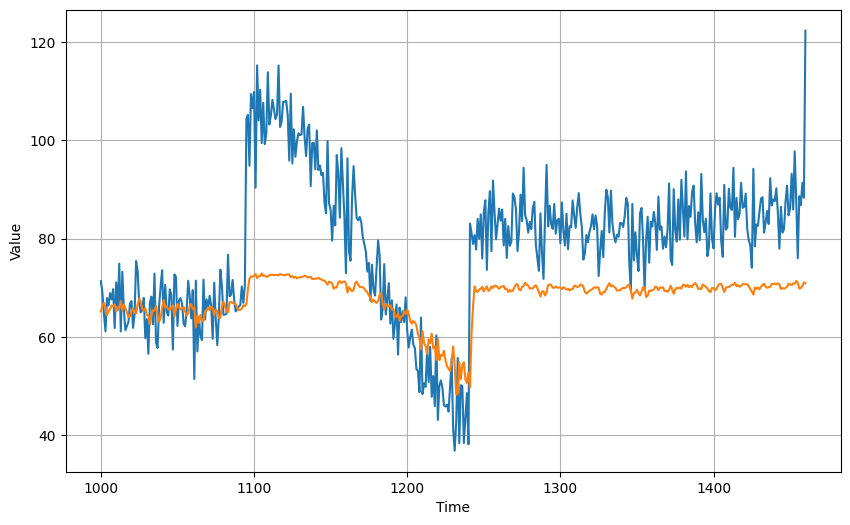

In [34]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [36]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

12.615481